## Filtros

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.filters import bk_filter, hp_filter, cf_filter
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter("ignore")

Importando serie del PBI

In [2]:
dta = pd.read_excel("./Bases de datos/PeruData.xlsx", sheet_name="Trimestral", skiprows=1)
dta = dta[['Trimestres', 'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI']]
dta.rename({'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI': 'PBI'}, axis=1, inplace=True)
dta = dta.loc[38:161, :]

# Seting index
dta.index = pd.period_range("1989Q3", "2020Q2", freq="Q")
dta.index=dta.index.to_timestamp()
dta = np.log(dta[["PBI"]])

### Filtros
Existe diferentes formas de filtrar una serie. Las que van a ser realizadas en esta seccion son las siguientes:
* Desestacionalizacion: ARIMA X13
* Modelo lineal
* Ucarima
* Filtro Hodrick-Prescott 
* Filtro Baxter-King
* Filtro Christiano-Fitzgerald

Hacia adelante se trabajara con la serie desestacionalizada por lo que:

In [3]:
desest = seasonal_decompose(dta.PBI, model="aditive")
desest_hat = desest.trend

dta["PBI_sa"] = desest_hat
dta = dta.dropna()

Es importante incluir una tendencia

In [4]:
dta["trend"] = range(len(dta.PBI))
dta["trend"] = dta["trend"] + 1
dta

,PBI,PBI_sa,trend
1990-01-01,10.607587,10.605748,1
1990-04-01,10.604527,10.561736,2
1990-07-01,10.432188,10.525852,3
1990-10-01,10.513254,10.511934,4
1991-01-01,10.499288,10.530360,5
...,...,...,...
2018-10-01,11.856429,11.809570,116
2019-01-01,11.756284,11.815159,117
2019-04-01,11.829360,11.821777,118
2019-07-01,11.835105,11.819252,119


In [5]:
X = dta.trend
y = dta.PBI_sa

#### 1. Modelo Lineal (OLS)

In [6]:
X = sm.add_constant(X)
modelo_lineal = sm.OLS(y, X).fit()
print(modelo_lineal.summary())

                            OLS Regression Results                            
Dep. Variable:                 PBI_sa   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     8173.
Date:                Mon, 07 Nov 2022   Prob (F-statistic):          8.17e-111
Time:                        12:17:08   Log-Likelihood:                 191.82
No. Observations:                 120   AIC:                            -379.6
Df Residuals:                     118   BIC:                            -374.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4659      0.009   1154.614      0.0

In [7]:
y_ols = modelo_lineal.predict(X)
y_ols_resid = y - y_ols


dta["ols_hat"] = y_ols
dta["ols_resid"] = y_ols_resid

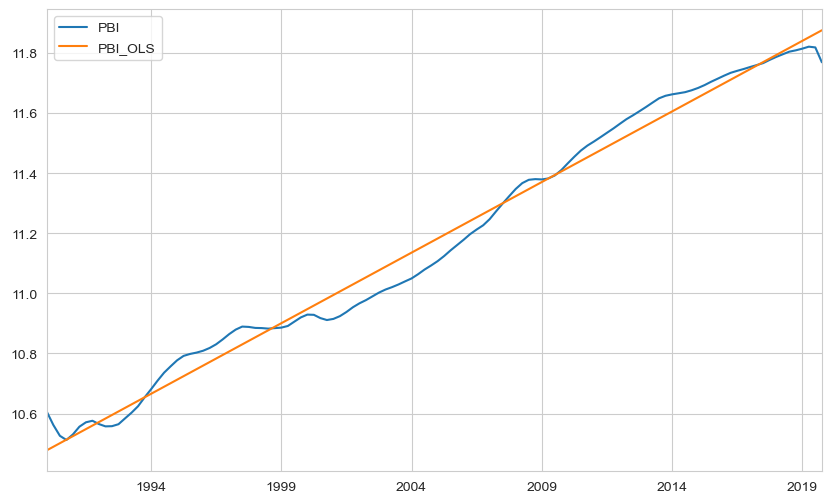

In [8]:
plt.figure(figsize=(10, 6))

y.plot(label="PBI")
dta.ols_hat.plot(label="PBI_OLS")
plt.legend()

plt.show()

#### 2. Ucarima
El modelo Ucarima se estima mediante un ARIMA de la siguiente manera:
$$ Y_t = \mu_t +\eta_t $$
$$ \mu_{t+1} = \mu_t + \epsilon_{t+1}$$

Donde, $\mu_t$ es la tendencia, modelada por un _random walk_

In [9]:
modelo_ucarima = tsa.UnobservedComponents(y, 'rwalk',autoregressive=1)
modelo_ucarima = modelo_ucarima.fit(method ='powell',disp=False)

print(modelo_ucarima.summary())

                        Unobserved Components Results                         
Dep. Variable:                 PBI_sa   No. Observations:                  120
Model:                    random walk   Log Likelihood                 327.440
                              + AR(1)   AIC                           -648.880
Date:                Mon, 07 Nov 2022   BIC                           -640.543
Time:                        12:17:09   HQIC                          -645.495
Sample:                    01-01-1990                                         
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     0.0002      0.000      1.608      0.108   -5.22e-05       0.001
sigma2.ar      4.16e-12      0.000   3.04e-08 

In [10]:
y_ucarima = modelo_ucarima.predict()
y_ucarima_resid = y - y_ucarima

dta["ucarima_hat"] = y_ucarima
dta["ucarima_resid"] = y_ucarima_resid

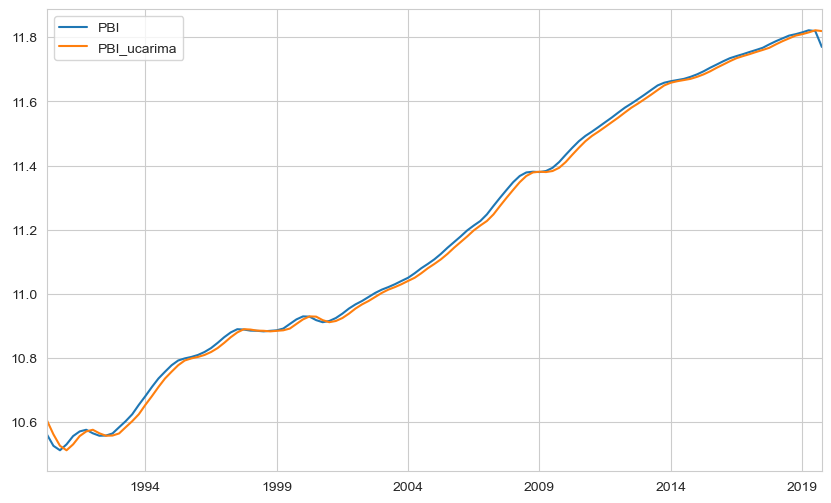

In [11]:
plt.figure(figsize=(10, 6))

y[1:].plot(label="PBI")
dta.ucarima_hat[1:].plot(label="PBI_ucarima")
plt.legend()

plt.show()

#### 3. Filtro Hodrick-Prescott
El filtro es estimado medainte la siguiente estimacion:
$$ min_{\tau_t} = \sum_{t=1}^{T} c_t^2 + \lambda \sum_{t=1}^{T}[(\tau_t - \tau_{t-1}) - (\tau_{t-1} - \tau_{t-2})]^2$$

Donde $\lambda$ es un parametro de ajuste que por lo general toma los siguientes valores:

* Mensual: 129600
* Trimestral: 1600
* Anual: 6.25

In [15]:
hp_cycle, hp_hat = hp_filter.hpfilter(y, lamb=1600)

dta["hp_hat"] = hp_hat
dta["hp_cycle"] = hp_cycle

In [16]:
dta

,PBI,PBI_sa,trend,ols_hat,ols_resid,ucarima_hat,ucarima_resid,desest_hat,desest_resid,hp_hat,hp_cycle
1990-01-01,10.607587,10.605748,1,10.477610,0.128138,0.000000,10.605748,NaN,NaN,10.512030,0.093717
1990-04-01,10.604527,10.561736,2,10.489364,0.072372,10.605748,-0.044011,NaN,NaN,10.520451,0.041286
1990-07-01,10.432188,10.525852,3,10.501118,0.024733,10.561736,-0.035884,10.541894,0.998486,10.528929,-0.003078
1990-10-01,10.513254,10.511934,4,10.512873,-0.000939,10.525852,-0.013918,10.531777,0.998161,10.537551,-0.025617
1991-01-01,10.499288,10.530360,5,10.524627,0.005733,10.511934,0.018427,10.536698,0.999413,10.546398,-0.016038
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,11.856429,11.809570,116,11.829348,-0.019778,11.805108,0.004462,11.809733,1.000031,11.801367,0.008203
2019-01-01,11.756284,11.815159,117,11.841102,-0.025943,11.809570,0.005589,11.814672,1.000056,11.807295,0.007864
2019-04-01,11.829360,11.821777,118,11.852856,-0.031079,11.815159,0.006619,11.811465,1.000805,11.813126,0.008652
2019-07-01,11.835105,11.819252,119,11.864611,-0.045358,11.821777,-0.002525,NaN,NaN,11.818888,0.000364


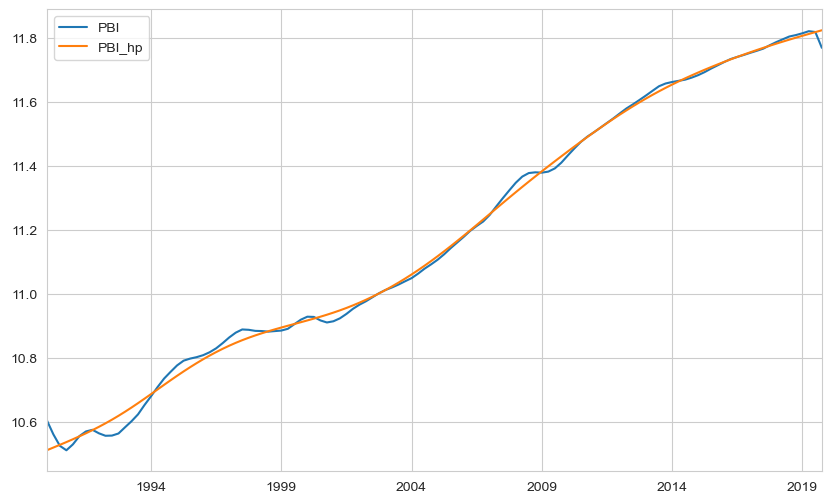

In [17]:
plt.figure(figsize=(10, 6))

y.plot(label="PBI")
dta.hp_hat.plot(label="PBI_hp")
plt.legend()

plt.show()

#### 4. Filtro Baxter-King
Este filtro es particular, por que requiere se pierdan una cierta cantidad de valores al inicio y al final

In [18]:
bk_cycle = bk_filter.bkfilter(y)
bk_trend = y - bk_cycle

dta["bk_trend"] = bk_trend
dta["bk_cycle"] = bk_cycle

In [19]:
dta

,PBI,PBI_sa,trend,ols_hat,ols_resid,ucarima_hat,ucarima_resid,desest_hat,desest_resid,hp_hat,hp_cycle,bk_trend,bk_cycle
1990-01-01,10.607587,10.605748,1,10.477610,0.128138,0.000000,10.605748,NaN,NaN,10.512030,0.093717,NaN,NaN
1990-04-01,10.604527,10.561736,2,10.489364,0.072372,10.605748,-0.044011,NaN,NaN,10.520451,0.041286,NaN,NaN
1990-07-01,10.432188,10.525852,3,10.501118,0.024733,10.561736,-0.035884,10.541894,0.998486,10.528929,-0.003078,NaN,NaN
1990-10-01,10.513254,10.511934,4,10.512873,-0.000939,10.525852,-0.013918,10.531777,0.998161,10.537551,-0.025617,NaN,NaN
1991-01-01,10.499288,10.530360,5,10.524627,0.005733,10.511934,0.018427,10.536698,0.999413,10.546398,-0.016038,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,11.856429,11.809570,116,11.829348,-0.019778,11.805108,0.004462,11.809733,1.000031,11.801367,0.008203,NaN,NaN
2019-01-01,11.756284,11.815159,117,11.841102,-0.025943,11.809570,0.005589,11.814672,1.000056,11.807295,0.007864,NaN,NaN
2019-04-01,11.829360,11.821777,118,11.852856,-0.031079,11.815159,0.006619,11.811465,1.000805,11.813126,0.008652,NaN,NaN
2019-07-01,11.835105,11.819252,119,11.864611,-0.045358,11.821777,-0.002525,NaN,NaN,11.818888,0.000364,NaN,NaN


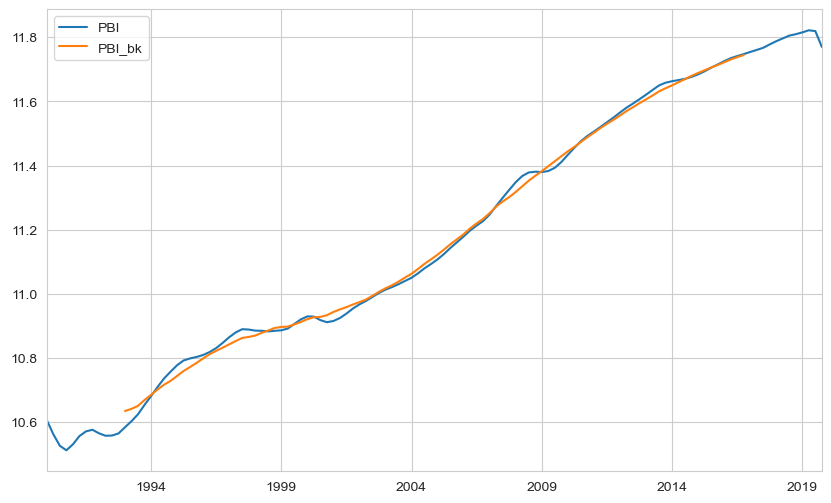

In [20]:
plt.figure(figsize=(10, 6))

y.plot(label="PBI")
dta.bk_trend.plot(label="PBI_bk")
plt.legend()

plt.show()

#### 5. Filtro Christiano-Fitzgerald

In [21]:
cf_cycle, cf_hat = cf_filter.cffilter(y, drift=False)

dta["cf_hat"] = cf_hat
dta["cf_cycle"] = cf_cycle

In [22]:
dta

,PBI,PBI_sa,trend,ols_hat,ols_resid,ucarima_hat,ucarima_resid,desest_hat,desest_resid,hp_hat,hp_cycle,bk_trend,bk_cycle,cf_hat,cf_cycle
1990-01-01,10.607587,10.605748,1,10.477610,0.128138,0.000000,10.605748,NaN,NaN,10.512030,0.093717,NaN,NaN,10.579060,0.026688
1990-04-01,10.604527,10.561736,2,10.489364,0.072372,10.605748,-0.044011,NaN,NaN,10.520451,0.041286,NaN,NaN,10.561685,0.000051
1990-07-01,10.432188,10.525852,3,10.501118,0.024733,10.561736,-0.035884,10.541894,0.998486,10.528929,-0.003078,NaN,NaN,10.550807,-0.024955
1990-10-01,10.513254,10.511934,4,10.512873,-0.000939,10.525852,-0.013918,10.531777,0.998161,10.537551,-0.025617,NaN,NaN,10.548060,-0.036127
1991-01-01,10.499288,10.530360,5,10.524627,0.005733,10.511934,0.018427,10.536698,0.999413,10.546398,-0.016038,NaN,NaN,10.559611,-0.029250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,11.856429,11.809570,116,11.829348,-0.019778,11.805108,0.004462,11.809733,1.000031,11.801367,0.008203,NaN,NaN,11.777259,0.032311
2019-01-01,11.756284,11.815159,117,11.841102,-0.025943,11.809570,0.005589,11.814672,1.000056,11.807295,0.007864,NaN,NaN,11.779748,0.035410
2019-04-01,11.829360,11.821777,118,11.852856,-0.031079,11.815159,0.006619,11.811465,1.000805,11.813126,0.008652,NaN,NaN,11.791600,0.030177
2019-07-01,11.835105,11.819252,119,11.864611,-0.045358,11.821777,-0.002525,NaN,NaN,11.818888,0.000364,NaN,NaN,11.802059,0.017193


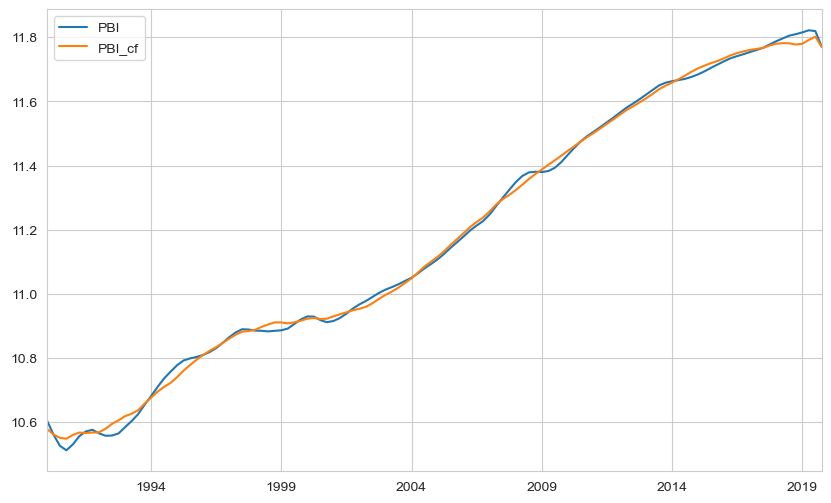

In [23]:
plt.figure(figsize=(10, 6))

y.plot(label="PBI")
dta.cf_hat.plot(label="PBI_cf")
plt.legend()

plt.show()

#### Comparacion

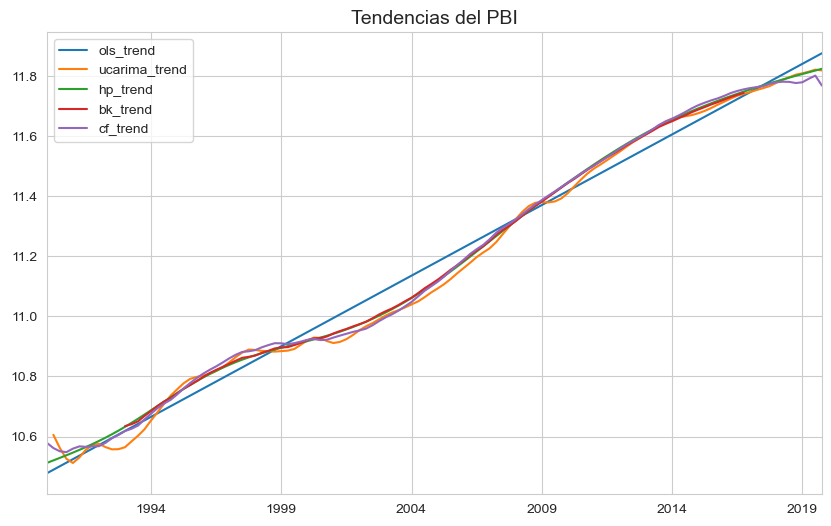

In [24]:
plt.figure(figsize=(10, 6))


dta.ols_hat.plot(label="ols_trend")
dta.ucarima_hat[1:].plot(label="ucarima_trend")
dta.hp_hat.plot(label="hp_trend")
dta.bk_trend.plot(label="bk_trend")
dta.cf_hat.plot(label="cf_trend")

plt.title("Tendencias del PBI", fontsize=14)
plt.legend()

plt.savefig("./Graficas/trends_pbi.pdf")
plt.show()

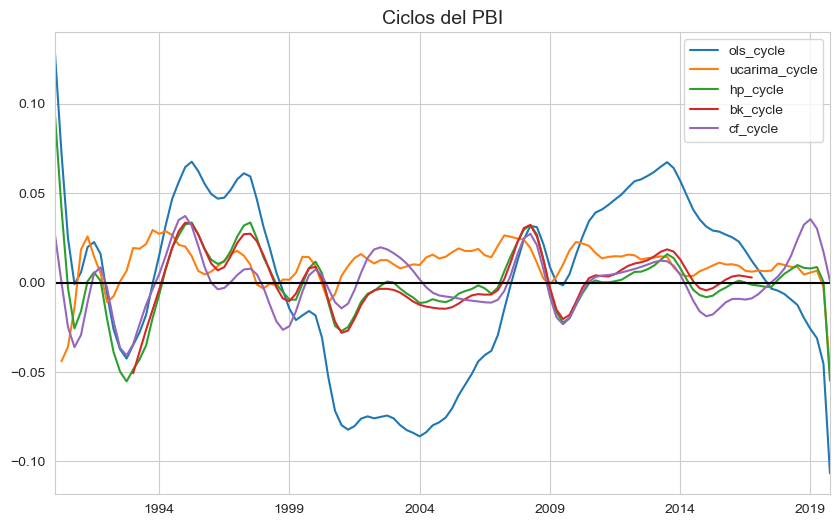

In [25]:
plt.figure(figsize=(10, 6))


dta.ols_resid.plot(label="ols_cycle")
dta.ucarima_resid[1:].plot(label="ucarima_cycle")
dta.hp_cycle.plot(label="hp_cycle")
dta.bk_cycle.plot(label="bk_cycle")
dta.cf_cycle.plot(label="cf_cycle")

plt.axhline(y = 0, color = "black", linestyle = "-")
plt.title("Ciclos del PBI", fontsize=14)
plt.legend()

plt.savefig("./Graficas/cycles_pbi.pdf")
plt.show()

#### Ciclos del PBI
Finalmente, se puede hacer un grafico conjunto para analizar cuales fueron los periodos donde el ciclo fue positivo o negativo. En este caso, tomare como referencia a los resultados del filtro HP

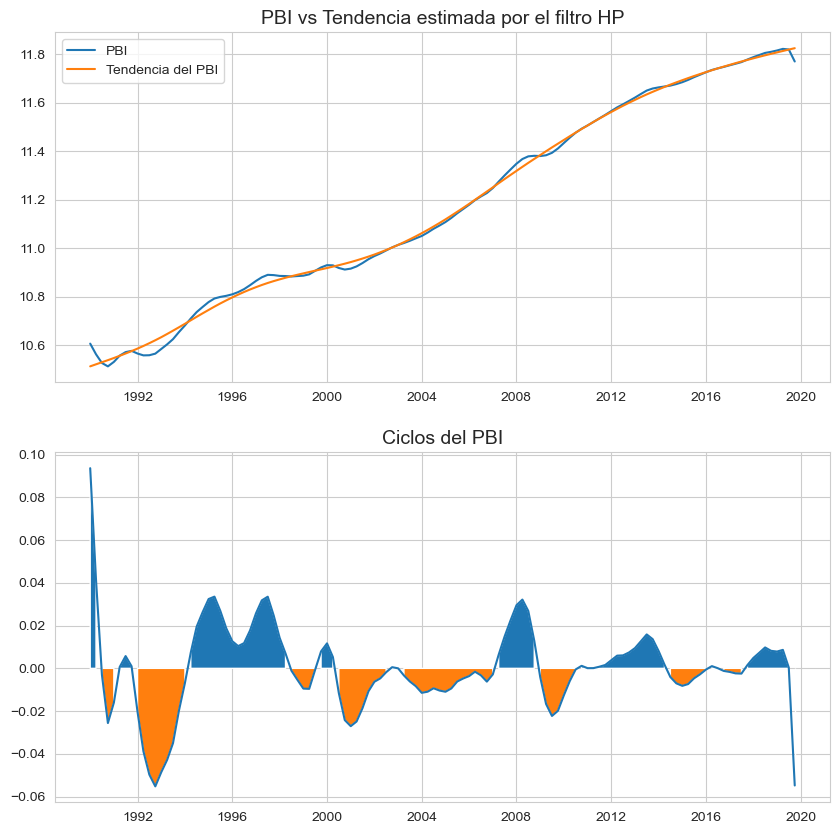

In [26]:
df_trend = pd.Series(index = y.index, data = hp_hat)
df_cycle = pd.Series(index = y.index, data = hp_cycle)

# Zero line
zero = [0 for t in hp_hat] 


fig, ax = plt.subplots(2, 1, figsize = (10, 10))

# Tendencias
ax[0].plot(y, label="PBI")
ax[0].plot(df_trend, label="Tendencia del PBI")

# Ciclos
ax[1].plot(df_cycle)
ax[1].fill_between(y.index,zero, df_cycle, where=df_cycle > 0)
ax[1].fill_between(y.index,zero, df_cycle, where=df_cycle < 0)

# Config
ax[0].set_title("PBI vs Tendencia estimada por el filtro HP", fontsize = 14)
ax[1].set_title("Ciclos del PBI", fontsize = 14)

ax[0].legend(loc="upper left")
plt.savefig("./Graficas/trend_cycle_pbi.pdf")

plt.show()

#### Referencias
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.bk_filter.bkfilter.html#statsmodels.tsa.filters.bk_filter.bkfilter
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html#statsmodels.tsa.filters.hp_filter.hpfilter
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.cf_filter.cffilter.html#statsmodels.tsa.filters.cf_filter.cffilter
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose